This notebook will cover experimental portfolio construction based on HRP (Hierarchical Risk Parity) concept first invented by Dr. Marcos Lopez de Prado (2016) that exploits graph theory and machine learning techniques. 

In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In order to test that HRP can differentiate even relatively "close sectors" company's I select the following stocks for portfolio construction

In [2]:
assets = ['MSFT','AAPL', 'GOOG','AMZN','TSLA','FB','NVDA','PYPL', 'INTC','AMD']

yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date='2010-01-01', 
                                                  end_date='2021-07-20', 
                                                  time_interval='daily')

prices_df = pd.DataFrame({
    a: {x['formatted_date']: x['close'] for x in data[a]['prices']} for a in assets
})

In [3]:
daily_returns = prices_df.pct_change()
daily_returns.describe()

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,PYPL,INTC,AMD
count,2904.000000,2904.000000,2904.000000,2904.000000,2782.000000,2305.000000,2904.000000,1520.000000,2904.000000,2904.000000
mean,0.000882,0.001167,0.000862,0.001324,0.002393,0.001213,0.001632,0.001607,0.000496,0.001385
std,0.015910,0.017812,0.016380,0.019788,0.035571,0.023317,0.026748,0.021762,0.018107,0.035850
min,-0.147390,-0.128647,-0.111008,-0.126568,-0.210628,-0.189609,-0.187559,-0.158239,-0.180415,-0.242291
25%,-0.006899,-0.007273,-0.006439,-0.008368,-0.015059,-0.009449,-0.011316,-0.009002,-0.008247,-0.016405
50%,0.000664,0.000903,0.000688,0.001107,0.001092,0.001050,0.001530,0.001442,0.000486,0.000000
75%,0.008728,0.010503,0.008777,0.011592,0.019130,0.012325,0.014341,0.012686,0.009210,0.018204
max,0.142169,0.119808,0.160524,0.157457,0.243951,0.296115,0.298067,0.141098,0.195213,0.522901


In [4]:
def plot_data(df, title="Stock prices"):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()


Snapshot of return dynamics to get an impression about volatility

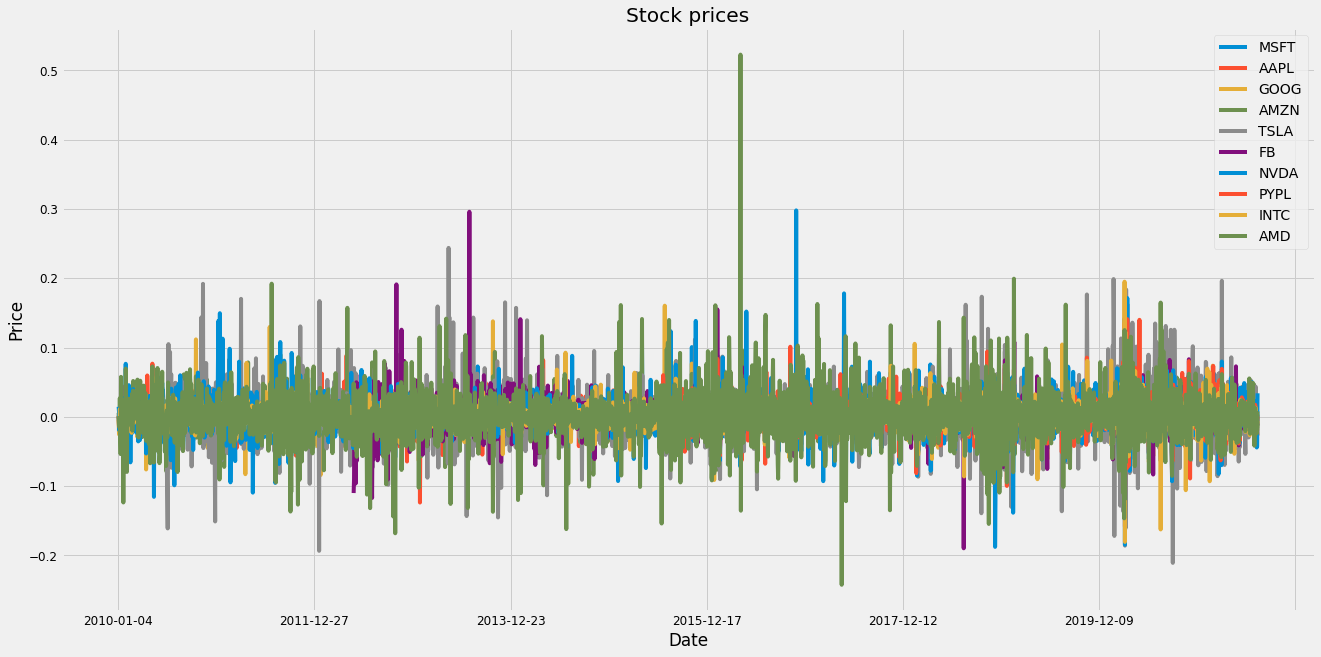

In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

plot = plot_data(daily_returns)


In [6]:
cov,corr=daily_returns.cov(),daily_returns.corr()


We can observe few ouliers in terms of linear dependence through correlation

In [7]:
corr.style.background_gradient(cmap='coolwarm')

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,PYPL,INTC,AMD
MSFT,1.000000,0.560498,0.612601,0.532755,0.326096,0.421521,0.535126,0.674720,0.597536,0.374216
AAPL,0.560498,1.000000,0.527722,0.455023,0.313804,0.402670,0.468444,0.588149,0.477729,0.358875
GOOG,0.612601,0.527722,1.000000,0.574982,0.305573,0.500462,0.470308,0.584833,0.456627,0.306724
AMZN,0.532755,0.455023,0.574982,1.000000,0.319935,0.456674,0.419047,0.546449,0.379856,0.330000
TSLA,0.326096,0.313804,0.305573,0.319935,1.000000,0.262521,0.322667,0.389734,0.276579,0.265883
FB,0.421521,0.402670,0.500462,0.456674,0.262521,1.000000,0.373438,0.577875,0.329041,0.227507
NVDA,0.535126,0.468444,0.470308,0.419047,0.322667,0.373438,1.000000,0.533973,0.511278,0.502464
PYPL,0.674720,0.588149,0.584833,0.546449,0.389734,0.577875,0.533973,1.000000,0.503725,0.348694
INTC,0.597536,0.477729,0.456627,0.379856,0.276579,0.329041,0.511278,0.503725,1.000000,0.378978
AMD,0.374216,0.358875,0.306724,0.330000,0.265883,0.227507,0.502464,0.348694,0.378978,1.000000


In [8]:
cov

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,PYPL,INTC,AMD
MSFT,0.000253,0.000159,0.000160,0.000168,0.000185,0.000161,0.000228,0.000253,0.000172,0.000213
AAPL,0.000159,0.000317,0.000154,0.000160,0.000198,0.000169,0.000223,0.000241,0.000154,0.000229
GOOG,0.000160,0.000154,0.000268,0.000186,0.000178,0.000187,0.000206,0.000219,0.000135,0.000180
AMZN,0.000168,0.000160,0.000186,0.000392,0.000224,0.000202,0.000222,0.000226,0.000136,0.000234
TSLA,0.000185,0.000198,0.000178,0.000224,0.001265,0.000215,0.000306,0.000305,0.000178,0.000340
FB,0.000161,0.000169,0.000187,0.000202,0.000215,0.000544,0.000224,0.000257,0.000143,0.000197
NVDA,0.000228,0.000223,0.000206,0.000222,0.000306,0.000224,0.000715,0.000340,0.000248,0.000482
PYPL,0.000253,0.000241,0.000219,0.000226,0.000305,0.000257,0.000340,0.000474,0.000226,0.000301
INTC,0.000172,0.000154,0.000135,0.000136,0.000178,0.000143,0.000248,0.000226,0.000328,0.000246
AMD,0.000213,0.000229,0.000180,0.000234,0.000340,0.000197,0.000482,0.000301,0.000246,0.001285


First I compute the most simple and intuitively appealling allocation metric based on inverse variance

In [9]:
def getIVP(cov, **kargs):
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

In [10]:
ivp = getIVP(cov)

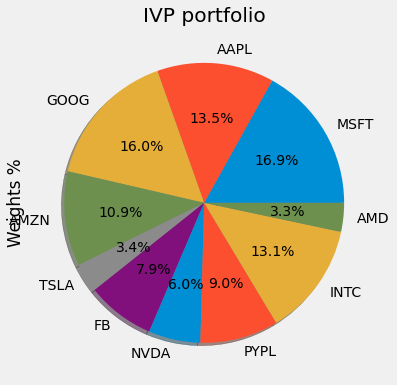

In [11]:
w = np.around(ivp*100, decimals=2)
w_ivp = pd.DataFrame(data = w)
w_ivp.columns =['Weights %']
w_ivp.index = assets
plot = w_ivp.plot.pie(y='Weights %', title="IVP portfolio", legend=False, autopct='%1.1f%%', 
                   shadow=True, startangle=0, figsize=(6, 6))

Construct distance matrix is based on correlation to avoid potential singularity with covariance matrix. The prove that this is realy a distance metric is given in the book "Advances in Financial Machine Learning" (AFML) by Dr. Marcos Lopez de Prado in the Appendix 16.A.1 p.239

Distance is a function that for each pair mapps a real number in the interval of [0;1].

In [12]:
def correlDist(corr):
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [13]:
dist = correlDist(corr)

Determining the clusters using the standartized linkage function from scipy library

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    

In [14]:
link = linkage(dist,'single')

<ipython-input-14-9619c5d8bddf>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist,'single')


Dendogram tree to visualise the conectedness of assets returns

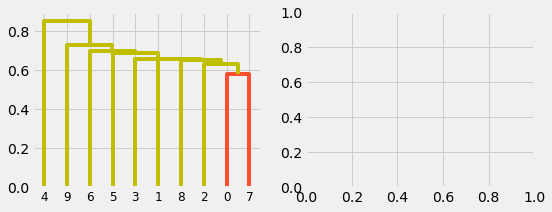

In [15]:
Z = pd.DataFrame(link)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y', orientation='top')
plt.show()

In [16]:
dist

,MSFT,AAPL,GOOG,AMZN,TSLA,FB,NVDA,PYPL,INTC,AMD
MSFT,0.000000,0.468776,0.440113,0.483345,0.580475,0.537810,0.482117,0.403286,0.448589,0.559367
AAPL,0.468776,0.000000,0.485941,0.522004,0.585746,0.546503,0.515537,0.453790,0.511014,0.566182
GOOG,0.440113,0.485941,0.000000,0.460987,0.589248,0.499769,0.514632,0.455613,0.521235,0.588760
AMZN,0.483345,0.522004,0.460987,0.000000,0.583123,0.521213,0.538959,0.476209,0.556841,0.578792
TSLA,0.580475,0.585746,0.589248,0.583123,0.000000,0.607239,0.581951,0.552389,0.601424,0.605854
FB,0.537810,0.546503,0.499769,0.521213,0.607239,0.000000,0.559715,0.459416,0.579206,0.621487
NVDA,0.482117,0.515537,0.514632,0.538959,0.581951,0.559715,0.000000,0.482715,0.494329,0.498767
PYPL,0.403286,0.453790,0.455613,0.476209,0.552389,0.459416,0.482715,0.000000,0.498134,0.570660
INTC,0.448589,0.511014,0.521235,0.556841,0.601424,0.579206,0.494329,0.498134,0.000000,0.557235
AMD,0.559367,0.566182,0.588760,0.578792,0.605854,0.621487,0.498767,0.570660,0.557235,0.000000


Forming clusters by distance metrics:cluster together the pair of columns (i∗, j∗) such that (i∗, j∗) =
argmin(i, j)i≠j{̃di,j} => that means we are taking the shortest distance between the first cluster and the item. After we define distance between cluster and left items. Then, update by appending new cluster and dropping the clustered columns and rows. Repeat the procedure until we cover all items in the portfolio.

In [17]:
def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [18]:
sortIx = getQuasiDiag(link)
sortIx
sortIx = corr.index[sortIx].tolist()

Augmenting clusters with variance/covariance data 

def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

Calculating HRP portfolio weigths

In [19]:
def getRecBipart(cov, sortIx):
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [20]:
w1 = getRecBipart(cov, sortIx)
np.around(w, decimals=3)

NameError: name 'getClusterVar' is not defined

In [ ]:
w = np.around(w1*100, decimals=2)
w_hrp = pd.DataFrame(data = w1)
w_hrp.columns =['Weights %']
w_hrp.index = assets
plot = w_ivp.plot.pie(y='Weights %', title="HRP portfolio", legend=False, autopct='%1.1f%%', 
                   shadow=True, startangle=0, figsize=(6, 6))

In [ ]:
df0=corr.loc[sortIx,sortIx]
df0

Convenient graph displaying the visual features of correlation matricies before/after clusterring

In [ ]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return

Type your directory to download the graphs

In [ ]:
import os

os.chdir("/Users/apple/Desktop/python")

plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)